# Window Convolution Series

Load modules.

In [1]:
import warnings
from itertools import product

warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import InterpolatedUnivariateSpline
from triumvirate._arrayops import reshape_threept_datatab
from triumvirate.transforms import resample_lglin
from triumvirate.winconv import (
    BispecWinConv,
    Multipole,
    ThreePointWindow,
    WinConvFormulae,
)

from config import DATADIR

Set I/O.

**NOTE**:
- Change `MULTIPOLE` to `'000'` for subfigures (a) (monopole), and `'202'` for subfigures (b) (quadrupole);
- Change `METRIC` to `'remove'` for Figure 6, and `'cascade'` for Figure 7.

In [2]:
MULTIPOLE = '000'  # '202'
METRIC = 'remove'  # 'cascade'

In [3]:
SUFFIX_BOX = "cubicbox_LRG_z0.500_mocks"
SUFFIX_SKY = "LRG_altmtl_SGC_0.4z0.6_mocks"
SUFFIX_PROXY = SUFFIX_BOX
SUFFIX_WIN = f"{SUFFIX_SKY}_18xF".replace('mocks', 'mock0')

In [4]:
# NOTE: Because 25 realisations are limited in number for covariance estimation,
# 12 bins are subselected.
BINIDX = list(range(1, 24, 2))
DDOF = len(BINIDX) - 1

Define window convolution formulae.

In [5]:
WINCONV_FORMULAE_REF = WinConvFormulae({
    '000': [
        ('000', '000', '1'),
        ('000', 'ic', '-1'),
        ('110', '110', '1/3'),
        ('220', '220', '1/5'),
        ('022', '022', '1/5'),
        ('202', '202', '1/5'),
        ('112', '112', '1/6'),
        ('132', '132', '1/9'),
        ('312', '312', '1/9'),
    ],
    '202': [
        ('000', '202', '1'),
        ('202', '000', '1'),
        ('202', 'ic', '-1'),
        ('110', '112', '1/3'),
        ('112', '110', '1/3'),
        ('110', '312', '1/3'),
        ('312', '110', '1/3'),
        ('202', '202', '2/7'),
        ('022', '220', '1/5'),
        ('220', '022', '1/5'),
        ('112', '112', '1/6'),
        ('312', '312', '8/63'),
        ('112', '312', '1/21'),
        ('312', '112', '1/21'),
        ('132', '132', '1/6'),
    ],
})

if MULTIPOLE == '000':
    WINCONV_FORMULAE_LEAD = WinConvFormulae({
        '000': [
            ('000', '000', '1'),
        ],
        '202': [
            ('000', '202', '1'),
            ('202', '000', '1'),
            ('110', '112', '1/3'),
            ('112', '110', '1/3'),
            ('110', '312', '1/3'),
            ('312', '110', '1/3'),
            ('202', '202', '2/7'),
            ('022', '220', '1/5'),
            ('220', '022', '1/5'),
            ('112', '112', '1/6'),
            ('312', '312', '8/63'),
            ('112', '312', '1/21'),
            ('312', '112', '1/21'),
            ('132', '132', '1/6'),
            ('202', 'ic', '-1'),
        ],
    })
elif MULTIPOLE == '202':
    WINCONV_FORMULAE_LEAD = WinConvFormulae({
        '000': [
            ('000', '000', '1'),
            ('110', '110', '1/3'),
            ('220', '220', '1/5'),
            ('022', '022', '1/5'),
            ('202', '202', '1/5'),
            ('112', '112', '1/6'),
            ('132', '132', '1/9'),
            ('312', '312', '1/9'),
            ('000', 'ic', '-1'),
        ],
        '202': [
            ('000', '202', '1'),
        ],
    })

Load unwindowed cubic-box and windowed cut-sky measurements.

In [6]:
results_bk_box = {}
results_bk_sky = {}
for multipole in WINCONV_FORMULAE_REF.multipoles:
    results_bk_box[multipole] = np.load(
        DATADIR / "common" / "unwindowed" /
        f"bk{multipole.abstr}_diag_{SUFFIX_BOX}.npy",
        allow_pickle=True,
    ).item()
    results_bk_sky[multipole] = np.load(
        DATADIR / "common" / "windowed" /
        f"bk{multipole.abstr}_diag_{SUFFIX_SKY}.npy",
        allow_pickle=True,
    ).item()

bk_box = {}
dbk_box = {}
for multipole in results_bk_box.keys():
    N_box = len(results_bk_box[multipole]['stats'])
    k_box = results_bk_box[multipole]['coords']
    bk_box[multipole] = results_bk_box[multipole]['stats_mean']
    dbk_box[multipole] = results_bk_box[multipole]['stats_std'] / np.sqrt(N_box)

bk_sky = {}
dbk_sky = {}
for multipole in results_bk_sky.keys():
    N_sky = len(results_bk_sky[multipole]['stats'])
    k_sky = results_bk_sky[multipole]['coords']
    bk_sky[multipole] = results_bk_sky[multipole]['stats_mean']
    dbk_sky[multipole] = results_bk_sky[multipole]['stats_std'] / np.sqrt(N_sky)

Estimate precision matrix.

In [7]:
invcov_sky = {}
for multipole in WINCONV_FORMULAE_REF.multipoles:
    invcov_sky[multipole] = np.linalg.inv(np.cov(
        np.subtract(
            results_bk_sky[multipole]['stats'],
            results_bk_sky[multipole]['stats_sn']
        )[:, BINIDX],
        rowvar=False
    ))

Load proxy model and resample log-linearly.

In [8]:
def load_model(winconv_formulae):

    results_bkk_proxy = {
        multipole: np.load(
            DATADIR / "common" / "model-proxy" /
            f"bk{multipole.abstr}_full_{SUFFIX_PROXY}.npy",
            allow_pickle=True,
        ).item()
        for multipole in winconv_formulae._multipoles_Z_true
    }

    k_proxy = None
    bkk_proxy = {}
    for multipole in winconv_formulae._multipoles_Z_true:
        k_proxy, bkk_proxy[multipole] = reshape_threept_datatab(
            results_bkk_proxy[multipole]['coords'],
            results_bkk_proxy[multipole]['stats_mean'],
            shape='triu' if multipole._issym() else 'full'
        )

    nsamp = 2 ** int(np.round(np.log2(k_proxy.size)))

    k_in = None
    bkk_in = {}
    for multipole in winconv_formulae._multipoles_Z_true:
        (k_in, _), bkk_in[multipole] = resample_lglin(
            k_proxy, bkk_proxy[multipole], nsamp, spline=1
        )

    return k_in, bkk_in

Load window function.

In [9]:
windows = ThreePointWindow.load_from_file(
    DATADIR / "common" / "windows" /
    f"zetaw_full_{SUFFIX_WIN}.npz"
)

Define loss function.

In [10]:
def loss_func(bk_conv_pole, bk_sky_pole, invcov_sky_pole, beta=0.):
    return (
        ((1 + beta) * bk_conv_pole - bk_sky_pole)[BINIDX].T
        @ invcov_sky_pole
        @ ((1 + beta) * bk_conv_pole - bk_sky_pole)[BINIDX]
    )

Evaluate loss function.

In [11]:
k_in, bkk_in = load_model(WINCONV_FORMULAE_REF)

winconv_ref = BispecWinConv(
    WINCONV_FORMULAE_REF, windows.r, windows.Q,
    k_in=k_in,
    transform_kwargs={
        'extrap': 5,
        'extrap2d': False,
    }
)

k_conv = winconv_ref.k_out
bkk_conv = winconv_ref.convolve(bkk_in, ret_zeta=False)

bk_conv_pole = InterpolatedUnivariateSpline(
    k_conv, np.diag(bkk_conv[Multipole(MULTIPOLE)]).real
)(k_sky)
loss_ref = loss_func(
    bk_conv_pole,
    bk_sky[Multipole(MULTIPOLE)],
    invcov_sky[Multipole(MULTIPOLE)]
)

In [12]:
loss_full = loss_func(
    np.zeros_like(bk_conv_pole),
    bk_sky[Multipole(MULTIPOLE)],
    invcov_sky[Multipole(MULTIPOLE)]
)

In [13]:
k_in, bkk_in = load_model(WINCONV_FORMULAE_LEAD)

winconv_lead = BispecWinConv(
    WINCONV_FORMULAE_LEAD, windows.r, windows.Q,
    k_in=k_in,
    transform_kwargs={
        'extrap': 5,
        'extrap2d': False,
    }
)

k_conv = winconv_lead.k_out
bkk_conv = winconv_lead.convolve(bkk_in, ret_zeta=False)

bk_conv_pole = InterpolatedUnivariateSpline(
    k_conv, np.diag(bkk_conv[Multipole(MULTIPOLE)]).real
)(k_sky)
loss_lead = loss_func(
    bk_conv_pole,
    bk_sky[Multipole(MULTIPOLE)],
    invcov_sky[Multipole(MULTIPOLE)]
)

Evaluate contributions.

In [14]:
partial_winconv_formulae = {}

if METRIC == 'remove':
    partial_winconv_formulae = {}
    for idx_term, term in enumerate(WINCONV_FORMULAE_REF[MULTIPOLE]):
        partial_formula = WinConvFormulae(WINCONV_FORMULAE_REF.get_dict())
        partial_formula[MULTIPOLE].pop(idx_term)
        partial_winconv_formulae[str(term)] = partial_formula

if METRIC == 'cascade':
    last_formula = WINCONV_FORMULAE_LEAD
    for idx_term, term in enumerate(WINCONV_FORMULAE_REF[MULTIPOLE]):
        current_formula = WinConvFormulae(last_formula.get_dict())
        if term not in last_formula[MULTIPOLE]:
            current_formula[MULTIPOLE].append(term)
        partial_winconv_formulae[str(term)] = current_formula
        last_formula = current_formula

In [15]:
losses_by_term = {}
for term in WINCONV_FORMULAE_REF[MULTIPOLE]:
    partial_formula_ = partial_winconv_formulae[str(term)]
    k_in_, bkk_in_ = load_model(partial_formula_)

    winconv_ = BispecWinConv(
        partial_formula_, windows.r, windows.Q,
        k_in=k_in_,
        transform_kwargs={
            'extrap': 5,
            'extrap2d': False,
        }
    )

    k_conv_ = winconv_.k_out
    bkk_conv_ = winconv_.convolve(bkk_in_, ret_zeta=False)
    bk_conv_pole_ = InterpolatedUnivariateSpline(
        k_conv_, np.diag(bkk_conv_[Multipole(MULTIPOLE)]).real
    )(k_sky)

    loss_value = loss_func(
        bk_conv_pole_,
        bk_sky[Multipole(MULTIPOLE)],
        invcov_sky[Multipole(MULTIPOLE)]
    )
    losses_by_term[str(term)] = loss_value

In [16]:
contribs = {}
for term in WINCONV_FORMULAE_REF[MULTIPOLE]:
    if METRIC == 'remove':
        contribs[str(term)] = 100 * (losses_by_term[str(term)] - loss_ref) / (loss_full - loss_ref)
    if METRIC == 'cascade':
        contribs[str(term)] = 100 * (loss_full - losses_by_term[str(term)]) / (loss_full - loss_ref)

In [17]:
winconv_formula_ref = WinConvFormulae({MULTIPOLE: WINCONV_FORMULAE_REF[MULTIPOLE]})

heatmat = np.zeros((
    len(winconv_formula_ref.multipoles_Z),
    len(winconv_formula_ref.multipoles_Q),
))

for ((idx_Z, multipole_Z), (idx_Q, multipole_Q)) in product(
    enumerate(winconv_formula_ref.multipoles_Z),
    enumerate(winconv_formula_ref.multipoles_Q),
):
    for term_ in WINCONV_FORMULAE_REF[MULTIPOLE]:
        if (term_.multipole_Z, term_.multipole_Q) == (multipole_Z, multipole_Q):
            term = term_
            break
    else:
        heatmat[idx_Z, idx_Q] = 0.
        continue

    if METRIC == 'add' and term in WINCONV_FORMULAE_LEAD[MULTIPOLE]:
        continue
    heatmat[idx_Z, idx_Q] = np.abs(contribs[str(term)])

np.save(
    DATADIR / "Figure_6" / f"winconv-contrib-weighting-{MULTIPOLE}.npy",
    heatmat
)

heatmat = np.ma.masked_where(heatmat == 0., heatmat)

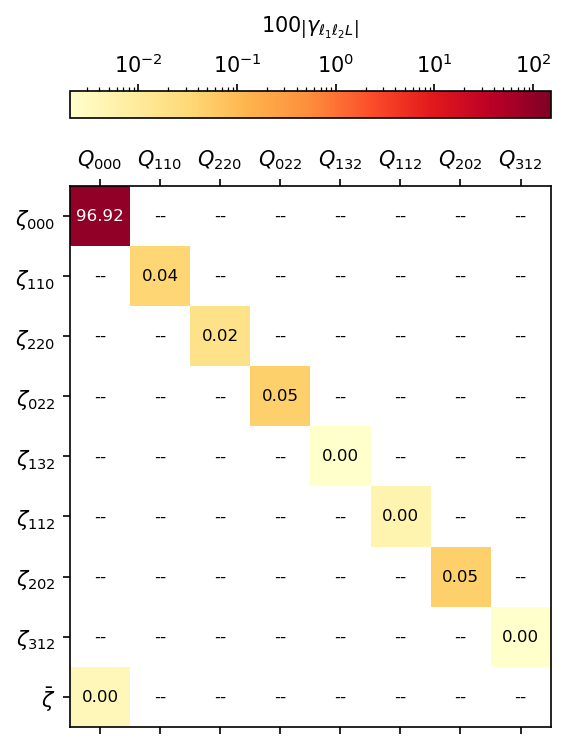

In [18]:
if METRIC != 'cascade':
    fig, ax = plt.subplots(figsize=(5.5, 5.5), dpi=150.)

    cax = ax.matshow(
        heatmat,
        norm=LogNorm(vmin=heatmat.min(), vmax=150.),
        cmap='YlOrRd',
    )

    if MULTIPOLE == '000':
        divider = make_axes_locatable(ax)
        cbar_ax = divider.append_axes('top', size='5%', pad=0.45)
        cbar = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal')

    for i in range(len(winconv_formula_ref.multipoles_Z)):
        for j in range(len(winconv_formula_ref.multipoles_Q)):
            if heatmat[i, j] > 80.:
                ax.text(
                    j, i,
                    f"{heatmat[i, j]:.2f}",
                    ha='center', va='center',
                    fontsize=8,
                    color='white',
                )
            else:
                ax.text(
                    j, i,
                    f"{heatmat[i, j]:.2f}",
                    ha='center', va='center',
                    fontsize=8,
                )

    ax.get_xaxis().set_ticks(range(len(winconv_formula_ref.multipoles_Q)))
    ax.get_yaxis().set_ticks(range(len(winconv_formula_ref.multipoles_Z)))

    xtick_labels = []
    for multipole_Q_ in winconv_formula_ref.multipoles_Q:
        xtick_labels.append(fr"$Q_{{{multipole_Q_.abstr}}}$")

    ytick_labels = []
    for multipole_Z_ in winconv_formula_ref.multipoles_Z:
        try:
            ytick_labels.append(fr"$\zeta_{{{multipole_Z_.abstr}}}$")
        except AttributeError:
            if multipole_Z_ == 'ic':
                ytick_labels.append(r"$\bar{\zeta}$")
            else:
                ytick_labels.append(fr"$\zeta_{{{multipole_Z_}}}$")

    ax.get_xaxis().set_ticklabels(xtick_labels);
    ax.get_yaxis().set_ticklabels(ytick_labels);

    if MULTIPOLE == '000':
        cbar.ax.xaxis.set_label_position('top')
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.set_label(r"$100\left\vert\gamma_{\ell_1 \ell_2 L}\right\vert$", labelpad=10)

In [19]:
if METRIC == 'cascade':

    fig, ax = plt.subplots(figsize=(4.5, 2.75), dpi=150.)

    x, y = [], []
    for idx_term, term in enumerate(WINCONV_FORMULAE_REF[MULTIPOLE]):
        x.append(idx_term)
        y.append(contribs[str(term)])

    np.save(
        DATADIR / "Figure_7" / f"winconv-contrib-cumweight-{MULTIPOLE}.npy",
        y
    )

    ax.plot(
        x, y,
        marker='o', markersize=5, color='C0', mfc='none',
        label=r"$\tilde{B}_{202}$"
    )
    ax.grid(axis='y', linestyle=':', linewidth=0.5)

    xtick_labels = []
    for idx_term, term in enumerate(WINCONV_FORMULAE_REF[MULTIPOLE]):
        if term.multipole_Z == 'ic':
            xlab = fr"$Q_{{{term.multipole_Q.abstr}}} \bar{{\zeta}}$"
        else:
            xlab = fr"$Q_{{{term.multipole_Q.abstr}}} \zeta_{{{term.multipole_Z.abstr}}}$"
        if idx_term > 0:
            xlab = '+' + xlab
        xtick_labels.append(xlab)

    ax.set_xticks(x)
    ax.set_xticklabels([])

    for i, xlab in enumerate(xtick_labels):
        ax.text(
            i - 0.2 if MULTIPOLE == '000' else i - 0.3,
            99.825 if MULTIPOLE == '000' else 99.825,
            xlab, ha='left', va='top',
            rotation=-45 if MULTIPOLE == '000' else -60
        )

    ax.set_ylabel(fr"$100(1 - \gamma_{{{MULTIPOLE}}})$")